In [3]:
%matplotlib inline
import autograd.numpy as np
import sys
sys.path.append('/Users/Cybele/GIT/birkhoff/birkhoff/')
sys.path.append('/Users/Cybele/GIT/birkhoff/src/')
sys.path.append('/Users/Cybele/GIT/birkhoff/')

import categorical as cat
import autograd.numpy.random as npr
from autograd import grad, jacobian
from autograd.optimizers import adam
from autograd.scipy.misc import logsumexp
from scipy.special import gammaln
from scipy.linalg import norm
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
seaborn.set_context("talk")
import cPickle


In [4]:
def pack_params(mu, logit_sigma):
    return np.concatenate((np.reshape(mu, mu.shape[0] * mu.shape[1]), np.reshape(logit_sigma, logit_sigma.shape[0] * logit_sigma.shape[1])))

def log_probability_gmm(x_n, pi_n, model_params):
    assert x_n.ndim == 1
    D = x_n.shape[0]
    mu, sigma, alpha = model_params

    E_x = np.dot(pi_n, mu.T)
    ll  = -0.5 * np.log(2 * np.pi * sigma**2) *  D
    ll = ll -0.5 * np.sum((x_n - E_x)**2 / sigma**2,axis =1)

    return ll


def logistic(psi): return np.exp(psi)/(1+np.exp(psi))

def unpack_params(params, N):
    
    D = np.shape(params)[-1] // 2
    logit_mus, logit_sigmas = params[:,:D], params[:,D:]
    return np.reshape(logit_mus, (N, -1)), np.reshape(logit_sigmas, (N, -1))

def sample_to_pi(sample, eps):
    discrete_matrix = np.zeros(sample.shape)
    discrete_matrix[np.arange(sample.shape[0]), np.argmax(sample, axis=1)] = 1
    return sample * eps + (1 - eps) * discrete_matrix


def sample_pi_voronoi(params, noise,  temp, limits):

    logit_mu, logit_sigma = unpack_params(params, noise.shape[0])
    mu = limits[0, 0] + (limits[0, 1] - limits[0, 0]) * logistic(logit_mu)
    sigma = limits[1, 0] + (limits[1, 1] - limits[1, 0]) * logistic(logit_sigma)
    sample = noise * sigma + mu
    return (sample, sample_to_pi(sample, temp))


def log_density_gaussian_voronoi(params, eps, limits):

    logit_mu, logit_sigma = unpack_params(params, 1)
    K = logit_mu.size
    sigma = limits[1, 0] + (limits[1, 1] - limits[1, 0]) * logistic(logit_sigma)
    log_sigma =np.log(sigma)
    entropy = 0.5 * log_sigma.size * (1.0 + np.log(2 * np.pi)) + np.sum(log_sigma)

    return entropy + K * np.log(eps)



def elbo_gmm_voronoi(x, var_params, model_params, N_samples, limits, temp, temp_prior):

    elbo = 0
    D = x.size
    K = model_params[0].shape[1]
    noise = npr.randn(N_samples, K)

    (sample, pi) = sample_pi_voronoi(np.tile(var_params,(N_samples,1)),noise, temp, limits)
        
    elbo = elbo + np.sum(log_probability_gmm(x, pi, model_params))
    elbo = elbo + log_mixture_gaussians(pi, np.identity(K), np.ones(K) * temp_prior)
    elbo = elbo + N_samples * log_density_gaussian_voronoi(np.tile(var_params,(1,1)), temp, limits)

    elbo /= N_samples

    return elbo


def log_evidence_cont(x_n, model_params, N_samples, alpha):
    assert x_n.ndim ==1
    mu, sigma, alpha = model_params
    K = mu.shape[1]

    epsilon = npr.uniform(0, 1, (N_samples, K))
    D = len(x_n)
    pi=np.zeros((N_samples,K))

    for n in range(N_samples):
        pi[n,:]=np.random.dirichlet(np.ones(K)* alpha)

    ll = -0.5 * np.log(2 * np.pi * sigma ** 2) * D
    ll = ll -0.5 * np.sum((x_n - mu.dot(pi[:,:].T).T)**2 / sigma**2, axis=1)
    return logsumexp(ll)-np.log(len(ll))

def log_mixture_gaussians(pi, mu, sigma):
    #computes the sum of log_mixture of gaussians over a sample of pi's (samples are stacked in the axis=0)
    N = pi.shape[1]
    n_components = len(sigma)
    n_samples = pi.shape[0]
    mu2 = np.tile(np.reshape(mu.T, (1, N, n_components)), (n_samples,1,1))
    pi2 = np.tile(np.reshape(pi,(n_samples,N,1)),(1, 1, n_components ))
    difs = np.sum(-0.5 * ((pi2 - mu2) **2. / (sigma **2.)), axis=1) + (-N * np.log(sigma)) -(0.5 * N) * np.log((2*np.pi) ) - np.log(n_components) 
    #print difs.shape
    #logs = np.log(np.sum(difs, axis =1) / n_components)
    
    return np.sum(logsumexp(difs, axis=1))
#log_mixture_gaussians(np.identity(5), np.identity(5), np.ones(5))

In [5]:
tau0=0.001 # initial temperature
np_temp=tau0
np_lr=0.001
step_size = 0.1

N_samples=10
ANNEAL_RATE=0.01
MIN_TEMP=0.001

N_iters = 100
N_samples=20

temps_prior=np.array([0.001])
K=5
N=1
D=2

sigma = 0.05
epsilon = 1e-12

N_simulations = 200
n_repetitions = 10
mu_gmm_all = np.zeros((N_simulations, D, K))
x_true_all = np.zeros((N_simulations, D))
z_true_all = np.zeros((N_simulations, K))
log_evidence_all = np.zeros((N_simulations, len(temps_prior), K))
posterior_all = np.zeros((N_simulations, K))


In [6]:

limits_voronoi = np.zeros((2,2))
limits_voronoi[0,0] = 0
limits_voronoi[0,1] = 1
limits_voronoi[1,0] = 0
limits_voronoi[1,1] = 0.2

var_params_voronoi = pack_params(0*np.random.randn(N,K), 0*np.random.randn(N,K))
N_samples_test=20


checkpoints = range(0,N_iters,1)

elbo_iterations = np.zeros( (len(temps_prior), N_simulations, n_repetitions, len(checkpoints)))
approx1 = np.zeros((len(temps_prior),  N_simulations, n_repetitions, len(checkpoints), K))
approx2 = np.zeros((len(temps_prior), N_simulations, n_repetitions, len(checkpoints), K))

dist1 = np.zeros( (len(temps_prior), N_simulations, n_repetitions, len(checkpoints)),)
dist2 = np.zeros( (len(temps_prior), N_simulations, n_repetitions, len(checkpoints)))


In [7]:
#Gradient ascent


#Temperature schedule
temps = np.zeros(N_iters)
for i in range(N_iters):
    if i % 10 ==0:
        np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    temps[i]=np_temp

for n in range(N_simulations):
        mu_gmm = npr.randn(D, K)
        sigma_gmm = 0.05
        alpha_gmm = np.ones(K)/K
        mu_gmm_all[n] = mu_gmm
        model_params = (mu_gmm, sigma_gmm, alpha_gmm)
        

        i_true = np.random.choice(K,1)
        z_true = np.zeros(K)
        z_true[i_true] = 1

        z_true_all[n]=z_true

        x_true = z_true.dot(mu_gmm.T)
        x_true += sigma_gmm * npr.randn(D)
        print x_true_all.shape
        print x_true.shape
        x_true_all[n,:] = x_true.T

        posterior = np.zeros(K)

        for kk in range(K):
            ek = np.zeros((1,K))

            ek[0,kk] = 1
            posterior[kk] = log_probability_gmm(x_true, ek, model_params)

        posterior = np.exp(posterior - logsumexp(posterior))
        posterior_all[n,:] = posterior


        for t in range(len(temps_prior)):
            elbo_voronoi = lambda x, temp: -1 * elbo_gmm_voronoi(x_true, x, model_params, N_samples, limits_voronoi, temps[temp], temps_prior[t])

            #log_evidence_all[n,t]=log_evidence_cont(x_true[0],model_params,1000)



            #print ((n,t,l,k), 'Begining Simulation ' + str(n) + ', temperature ' + str(temps_prior[t]) + ', method: ' + types[l]  + ', and true class ' + str(k))
            for r in range(n_repetitions):
                variational_params,varseq = adam(grad(elbo_voronoi), pack_params(np.random.randn(N,K), np.random.randn(N,K)), step_size=step_size, num_iters=N_iters)

                for (i,c) in enumerate(checkpoints):


                    elbo_iterations[t, n, r, i] = elbo_gmm_voronoi(x_true, varseq[c], model_params,  N_samples, limits_voronoi, temps[c], temps_prior[t])

                    pi_samples = np.reshape(np.asarray([sample_pi_voronoi(np.reshape(varseq[c],(1,-1)), npr.randn(N,K ), temps[c], limits_voronoi)[1]
                                    for _ in range(N_samples_test)]),(N_samples_test,K))                  


                    one_hot=np.zeros((N_samples_test,K))
                    one_hot[range(N_samples_test),np.argmax(pi_samples,axis=1)] = 1

                    approx1[t, n , r, i,:] = np.mean(one_hot, axis=0)
                    approx2[t, n, r,i,:] = np.mean(pi_samples,axis=0)
                    dist1[t, n, r, i]=max(abs(posterior-approx1[t, n, r, i,:]))
                    dist2[t, n, r, i]=max(abs(posterior-approx2[t, n, r, i,:]))
                print ('Final Elbo', elbo_iterations[t, n,r, -1])
                print ('Final Error', dist1[ t, n, r, -1])
                print np.mean(one_hot, axis=0)
                print np.isnan(elbo_iterations[t, n, r]).any()
            #print pi_samples

(200, 2)
(2,)
('Final Elbo', -25.358665774997718)
('Final Error', 0.99999999961753006)
[ 1.  0.  0.  0.  0.]
False
('Final Elbo', -728.91744028662993)
('Final Error', 0.79999999961752999)
[ 0.    0.1   0.2   0.15  0.55]
False
('Final Elbo', -3.6623958375155667)
('Final Error', 3.8247005562652703e-10)
[ 0.  0.  1.  0.  0.]
False
('Final Elbo', -25.340265090969687)
('Final Error', 0.99999999961753006)
[ 1.  0.  0.  0.  0.]
False
('Final Elbo', -3.6735142509425716)
('Final Error', 3.8247005562652703e-10)
[ 0.  0.  1.  0.  0.]
False
('Final Elbo', -3.6886478164782317)
('Final Error', 3.8247005562652703e-10)
[ 0.  0.  1.  0.  0.]
False
('Final Elbo', -607.7548232641044)
('Final Error', 0.99999999961752994)
[ 0.05  0.05  0.    0.25  0.65]
False
('Final Elbo', -25.341107698626768)
('Final Error', 0.99999999961753006)
[ 1.  0.  0.  0.  0.]
False
('Final Elbo', -3.6602033924680368)
('Final Error', 3.8247005562652703e-10)
[ 0.  0.  1.  0.  0.]
False
('Final Elbo', -778.8580694941254)
('Final Err

KeyboardInterrupt: 

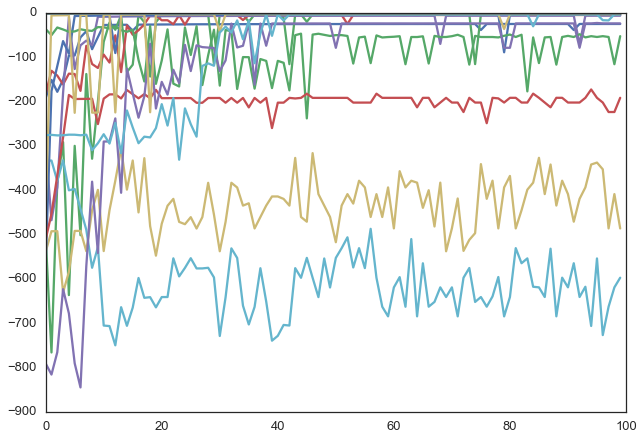

In [8]:
plt.plot(elbo_iterations[0,:,0,:].T)

(0, 2)

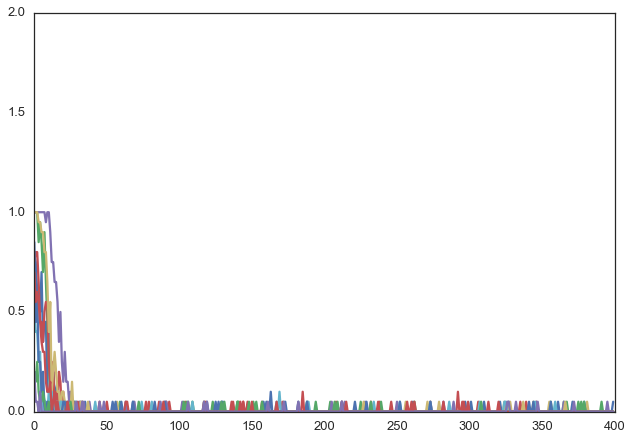

In [1112]:
plt.plot(dist1elbo_iterations[0,:,0,:].T)
plt.ylim(0,2)

[[ -1.62842570e-04  -1.64184928e-04  -5.24997588e-05   4.14572714e-04
   -3.93610192e-04  -3.70152888e-04  -2.66677310e-04  -1.72403679e-04
    6.72226738e-05   9.99732741e-01]
 [ -2.06021582e-04   3.46245205e-04  -8.85556938e-06   4.12041248e-04
    6.57156695e-05  -3.52469866e-04  -1.92567935e-04   7.28697301e-05
    2.26768391e-04   9.99658620e-01]
 [ -2.39471850e-05   3.61297298e-05  -1.35193809e-04  -4.94775807e-06
    2.34072182e-04   6.60963430e-05  -4.22746893e-05   9.80696938e-05
    5.84267663e-04   9.99758468e-01]
 [  1.21912344e-05   2.14670837e-04  -1.39313296e-04   3.58774680e-04
    2.33473454e-04  -3.57139164e-04   2.25768624e-04   2.06074473e-04
    1.45201946e-04   9.99992793e-01]
 [  8.01869823e-06   1.08228696e-04  -1.06877461e-05   4.98263563e-05
   -2.93889071e-04  -3.53821909e-04   1.40752026e-04  -1.03910265e-04
    1.39438786e-04   9.99631906e-01]
 [ -2.61056665e-05  -1.37662095e-04  -3.32667675e-04  -2.99461498e-04
   -1.39127435e-04  -1.89332845e-04  -5.09963

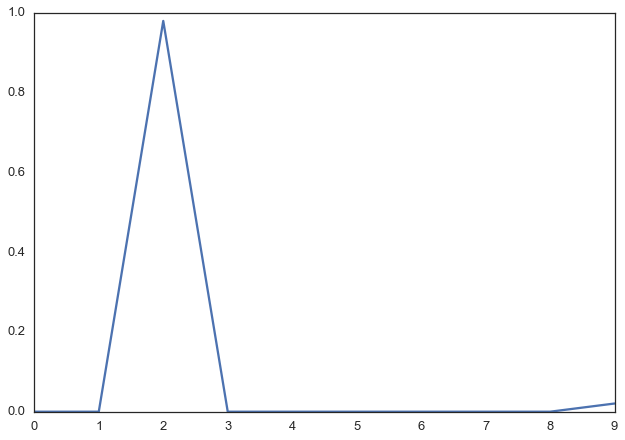

In [1099]:

#plt.plot(varseq[:,:5])
#print varseq[:,:5]
#plt.plot(elbo_iterations[0,0,:,0,:].T)
#plt.plot(dist1[0,0,4,0,:])
print pi_samples
print posterior
print varseq.shape
logit_mu, logit_sigma = unpack_params(varseq, varseq.shape[0] )
mu = limits_voronoi[0, 0] + (limits_voronoi[0, 1] - limits_voronoi[0, 0]) * logistic(logit_mu)
plt.plot(posterior)
print np.mean(pi_samples, axis=0)

IndexError: invalid index to scalar variable.

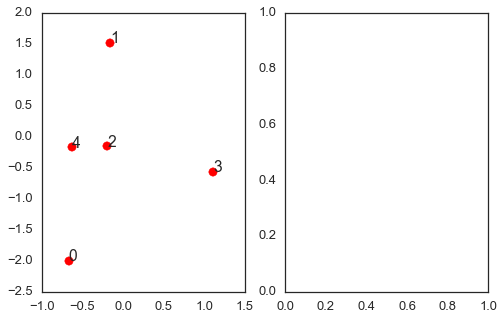

In [800]:
#plt.plot(elbo_iterations)
f, ax = plt.subplots(1, 2, sharey=False, figsize=(8, 5))
ax[0].scatter(mu_gmm[0],mu_gmm[1],color='red',s=70)
for t,i in enumerate(zip(mu_gmm[0],mu_gmm[1])):
    ax[0].annotate(str(t), xy=i, xytext=i)

ax[0].scatter(x_true[0][0],x_true[0][1],color='blue',s=70)
ax[1].bar(np.arange(10), posterior, align='center')
print range(0,10,2)


In [ ]:
np.mean(dist1[:,1,-1,1:180,-5],axis=(1))

In [ ]:


N_samples_test=20

elbo_iterations=np.zeros((len(indtypes),N_iters))
approx=np.zeros((len(indtypes),N_iters,K))
dist = np.zeros((len(indtypes),N_iters))
#print elbos[l](x_true, var_params_gaussian, model_params, temp_prior,N_samples,epsilon)
for j,l in enumerate(indtypes):
    print 'Begining ' +types[l]  
    variational_params,varseq = adam(grad(functions[l]), var_params[l], step_size=step_size, num_iters=N_iters)
    
    for i in range(varseq.shape[0]):
       
        if(l==0):
            elbo_iterations[j,i] = elbos[l](x_true, varseq[i], model_params, temp_prior, N_samples, epsilon, limits_gaussian, temps[i])
       
            pi_samples = np.reshape(np.asarray([functions_sample[l](np.reshape(varseq[i],(1,-1)), npr.randn(N,K - 1), epsilon, limits_gaussian, temps[i])[2]
                            for _ in range(N_samples_test)]),(N_samples_test,K))
        if(l==1): 
            elbo_iterations[j,i] = elbos[l](x_true, varseq[i], model_params, temp_prior, N_samples, temps[i])
       
            pi_samples = np.reshape(np.asarray([functions_sample[l](varseq[i], npr.uniform(0,1,(N,K)), temps[i])
                            for _ in range(N_samples_test)]), (N_samples_test,K))
        if(l==2):
            elbo_iterations[j,i] = elbos[l](x_true, varseq[i], model_params, temp_prior, N_samples, epsilon, limits_kumaraswamy)
       
            pi_samples = np.reshape(np.asarray([functions_sample[l](np.reshape(varseq[i],(1,-1)), npr.uniform(0,1,(N,K - 1)), epsilon, limits_kumaraswamy)[1]
                               for _ in range(N_samples_test)]),(N_samples_test,K))

        
        one_hot=np.zeros((N_samples_test,K))
        one_hot[range(N_samples_test),np.argmax(pi_samples,axis=1)]=1
        #if i % 10 == 0:
         #   print pi_samples
        approx[j,i,:] = np.mean(one_hot,axis=0)
        dist[j,i]=max(abs(posterior-np.mean(one_hot,axis=0)))
    #print types[l] + 'Done'
    #print np.round(100*pi_samples)/100
    #print 'caca'
    #print np.mean(np.round(100*pi_samples)/100,axis=0)
    #print approx[j,-1,:]

In [ ]:
print approx[0,0:100]
print type(temps[0])#print varseq[69]
#for e in range(10):
 #   elbos[0](x_true, varseq[110], model_params, temp_prior,N_samples)
#N_samples=5
#print np.concatenate((varseq, np.reshape(np.arange(50),(-1,1))),axis=1)

n=0

temp=1
#print np.log(a)
#temp_prior = 0.0001
alpha = np.ones(K)*temp_prior/1000

for i in range(0):
    #noise=npr.randn(N_samples, N, K -1 )
    noise=npr.uniform(0,1,(N_samples, N, K -1 ))
    #(sample,psi,pi)= cat.sample_pi_gaussian(np.tile(varseq[199],(N_samples,1)),np.reshape(noise[:,n,:],(N_samples,K-1)), epsilon,max_sigma)
    (psi,pi)= cat.sample_pi_kumaraswamy(np.tile(varseq[30],(N_samples,1)),np.reshape(noise[:,n,:],(N_samples,K-1)), epsilon)
    #print psi
    #print pi
    #pi = np.maximum(pi, 1e-30)
    #pi = (pi.T / np.sum(pi, axis=1)).T
    #print a
    #print np.log(a)
    #print(np.dot(np.log(a),alpha-1),-np.sum(gammaln(alpha)),gammaln(np.sum(alpha)))
    #print (cat.local_log_probability_gmm(x_true[0], pi, model_params),np.sum(cat.dirichlet_logpdf_psi(psi,np.ones(K)*temp_prior)),
    #       - np.sum(cat.log_density_gaussian_psi(sample, np.tile(varseq[199],(N_samples,1)), epsilon,max_sigma)))
    #print (cat.local_log_probability_gmm(x_true[0], pi, model_params),np.sum(cat.dirichlet_logpdf_pi(pi,np.ones(K)*temp_prior)),
     #      - np.sum(cat.log_density_pi_gaussian_pi(pi, np.tile(varseq[142],(N_samples,1)), 1)))
    print (cat.local_log_probability_gmm(x_true[0], pi, model_params),np.sum(cat.dirichlet_logpdf_psi(psi,np.ones(K)*temp_prior)),
           - np.sum(cat.log_density_kumaraswamy_pi(pi, np.tile(varseq[30],(N_samples,1)))))
    
    #print sample
    #print psi
    #print pi
    assert np.isfinite(np.sum(cat.log_density_gaussian_psi(psi, np.tile(varseq[30],(N_samples,1)), epsilon,max_sigma)))
N_samples =  1
noise = npr.uniform(0,1,(N_samples,1,K - 1))
(psi,pi)= cat.sample_pi_kumaraswamy(np.tile(varseq[30],(N_samples,1)),np.reshape(noise[:,n,:],(N_samples,K-1)), epsilon)

K = psi.shape[1]+1

loga, logb = cat.unpack_kumaraswamy_params(np.tile(varseq[30],(N_samples,1)), N_samples)

seq = np.flipud(np.arange(K-2)+1)
#return  np.sum(loga + logb + (np.exp(loga) - 1) * np.log(psi) + (np.exp(logb) - 1) * np.log( 1 - np.power(psi, np.exp(loga))),axis=1)
#-np.dot(seq, np.log(1 - psi[:,:K-2]).T).T,
#print (np.sum(loga + logb + (np.exp(loga) - 1) * np.log(psi) + (np.exp(logb) - 1) * np.log( 1 - np.power(psi, np.exp(loga))),axis=1))
#print loga + logb 
#print (np.exp(loga) - 1) * np.log(psi) 
print psi[:,8]
print pi
print (np.exp(logb[:,8]) - 1) 
print np.log1p(- np.power(psi[:,8], np.exp(loga[:,8])))
print np.log(1- np.exp(np.log(psi[:,8]) * np.exp(loga[:,8])))

print np.exp(np.log(psi[:,8]) * np.exp(loga[:,8]))
print np.power(psi[:,8], np.exp(loga[:,8]))
print 
   # assert b is not float('inf')
#for i in range(30):
#for i in range(30):
 #   print grad(functions[0])(varseq[77],1)
#print varseq[107]
print np.exp(loga[0,:])
#print logb[0,:]

In [ ]:
#plt.plot(dictionary['elbos'][1][iter_ind,3],'blue')
plt.plot(elbo_iterations[0],'red')
plt.plot(elbo_iterations[1],'blue')
plt.plot(elbo_iterations[2],'green')
plt.plot([0,N_iters],[log_evidence,log_evidence])
#print elbo_iterations[0]
#print variational_params
#print functions_sample[1](varseq[0][:len(varseq[0])-1], npr.uniform(0,1,(N,K)),temp = np.exp(varseq[0][-1]))
#print varseq[200][:len(varseq[0])-1]
#print varseq[0]
#print elbos[0]
#print functions_sample[0](np.reshape(varseq[0],(1,-1)), npr.randn(N,K - 1), 1,0.999999)[2].shape

#pi_samples = np.reshape(np.asarray([functions_sample[l](np.reshape(varseq[400],(1,-1)), npr.randn(N,K - 1), epsilon,max_sigma)[2]
 #                           for _ in range(N_samples_test)]),(N_samples_test,K))

#print x_true[0]
#print mu_gmm[:,7]
#print np.dot(pi_samples  ,mu_gmm.T) 
print elbo_iterations[0][30]
#print varseq
print varseq
#print pi_samples

#print  elbos[2](x_true, varseq[199], model_params, temp_prior,N_samples,epsilon)

In [ ]:
plt.plot(dist[1],'blue')
plt.plot(dist[0],'red')
plt.plot(dist[2],'green')
#plt.plot(dictionary['dists'][1][iter_ind,3,:],'green')


In [ ]:
print varseq[68]

In [ ]:
print variational_params

In [ ]:
print variational_params

In [ ]:
print varseq[100,:]

In [ ]:
print approx[0][0:100,:]

In [ ]:
print approx[0]

In [ ]:
print mu_gmm_all

In [ ]:
dict={'mu_gmm_all':mu_gmm_all,'z_true_all':z_true_all,'x_true_all':x_true_all, 'log_evidence_all':log_evidence_all,'posterior_all':posterior_all\
      ,'elbo_iterations':elbo_iterations,'approx1':approx1,'dist1':dist1,'dist2':dist2,'Ns':(D,N,K,N_samples)}
cPickle.dump( dict, open( "save_k5.p", "wb" ))